# 新規材料の予測

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.2)  # seabornスタイル適用
import numpy as np
import pandas as pd

from sklearn.cross_decomposition import PLSRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import optuna

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pickle

from scipy.spatial.distance import cdist
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

## データ読み込み＆前処理

In [6]:
# 入力：読み込みたい記述子のタイプを選択
descriptor_type = 'mordred_3d'  # 'rdkit' or 'mordred_2d' or 'mordred_3d'

# ベースのデータ
dataset = pd.read_csv('material_data.csv', index_col=0)

# 条件に応じて記述子ファイルを読み込む
if descriptor_type == 'rdkit':
    des = pd.read_csv('descriptor_rdkit.csv', index_col=0)
elif descriptor_type == 'mordred_2d':
    des = pd.read_csv('descriptor_mordred_2d.csv', index_col=0)
elif descriptor_type == 'mordred_3d':
    des = pd.read_csv('descriptor_mordred_3d.csv', index_col=0)
else:
    raise ValueError(f"未知のdescriptor_type: {descriptor_type}")

# 結合
dataset_full = pd.concat([dataset.reset_index(), des.reset_index(drop=True)], axis=1)
dataset_full = dataset_full.set_index('Material')

# 確認
print(dataset.shape, des.shape, dataset_full.shape)

(233, 3) (233, 1826) (233, 1829)


In [7]:
# TypeとSMILESも消す
dataset_full = dataset_full.drop(['SMILES', 'Type'], axis=1)

# 学習用と予測用に分ける
dataset_train = dataset_full.dropna(subset=['PL']).copy()
dataset_test = dataset_full[dataset_full['PL'].isnull()].copy()

# 予測データのPLは空なので消す
dataset_test = dataset_test.drop('PL', axis=1)

# 1. 両方のデータセットでinfをNaNに置き換える
dataset_train.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. 学習データに基づいて削除すべき列を特定する
#    - NaNを含む列
nan_cols = dataset_train.columns[dataset_train.isnull().any()]
#    - 標準偏差が0の列
zero_std_cols = dataset_train.columns[dataset_train.std() == 0]

#    - 削除する列の全リスト (重複をなくす)
cols_to_drop = nan_cols.union(zero_std_cols)
print(f"学習データに基づいて削除する列の数: {len(cols_to_drop)}")


# 3. 特定した同じ列を「両方のデータセット」から削除する
dataset_train.drop(columns=cols_to_drop, inplace=True)
dataset_test.drop(columns=cols_to_drop, inplace=True, errors='ignore') # テストデータにその列がなくてもエラーにしない

# 4. テストデータに残っているNaNを「学習データの平均値」で埋める
#    まず、学習データから各列の平均値を計算します。
imputation_values = dataset_train.drop('PL', axis=1).mean()

#    計算した平均値を使ってテストデータの欠損値を埋めます。
dataset_test.fillna(imputation_values, inplace=True)

print("\n処理後のshape:")
print(dataset_train.shape, dataset_test.shape)

# 列数が一致していることを確認
if dataset_train.shape[1] - 1 == dataset_test.shape[1]:
    print("✅ 列数が一致しました！ (学習データ: 目的変数分+1)")
else:
    print("❌ 列数が一致していません。")

学習データに基づいて削除する列の数: 604

処理後のshape:
(228, 1223) (5, 1222)
✅ 列数が一致しました！ (学習データ: 目的変数分+1)


In [8]:
# 最終的な特徴量共通セット
X_train_all = dataset_train.drop(columns='PL')
y_train_all = dataset_train['PL']
X_test = dataset_test  # PLなし

## RandomForest

In [9]:
def objective_rf(trial):
    # 検証するパラメータ
    params = {
    "n_estimators" : trial.suggest_int('n_estimators', 50, 500),
    "max_depth" : trial.suggest_int('max_depth', 3, 20),
    "min_samples_split" : trial.suggest_int('min_samples_split', 2, 10),
    "min_samples_leaf" : trial.suggest_int('min_samples_leaf', 1, 10),
    "max_features" : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    'random_state' : 1234,  # 再現性のため
    'n_jobs' : -1
    }

    # モデル定義
    model_rf = RandomForestRegressor(**params)

    # 分割、CV
    kf = KFold(n_splits=5, shuffle=True, random_state=1234)

    # 評価指標
    rmse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X_train_all):
        # 訓練と検証に分類
        X_train, X_val = X_train_all.iloc[train_index, :], X_train_all.iloc[val_index, :]
        y_train, y_val = y_train_all.iloc[train_index], y_train_all.iloc[val_index]

        # 標準化、DataFrameに戻す
        std = StandardScaler()
        autoscaled_X_train = pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
        autoscaled_X_val = pd.DataFrame(std.transform(X_val), columns=X_val.columns, index=X_val.index)

        # 学習
        model_rf.fit(autoscaled_X_train, y_train)
        y_pred = model_rf.predict(autoscaled_X_val)

        # 性能チェック
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        # 結果格納
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    return np.mean(r2_scores)  # 最適化したい評価指標を選ぶ



In [10]:
# 最適化
study = optuna.create_study(direction='maximize', study_name='regression')
study.optimize(objective_rf, n_trials=100)

[I 2025-07-13 20:22:06,826] A new study created in memory with name: regression
[I 2025-07-13 20:22:10,163] Trial 0 finished with value: 0.7439740538151047 and parameters: {'n_estimators': 97, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.7439740538151047.
[I 2025-07-13 20:22:12,051] Trial 1 finished with value: 0.7145731764050323 and parameters: {'n_estimators': 141, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7439740538151047.
[I 2025-07-13 20:22:15,517] Trial 2 finished with value: 0.724198679025448 and parameters: {'n_estimators': 247, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7439740538151047.
[I 2025-07-13 20:22:18,339] Trial 3 finished with value: 0.7260933736583729 and parameters: {'n_estimators': 199, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_le

In [11]:
# the best parameters
print('best parameters', study.best_params)
# the best value
print('best value', study.best_value)
# the best trial
print('best trials', study.best_trial)

best parameters {'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
best value 0.789043642422008
best trials FrozenTrial(number=74, state=TrialState.COMPLETE, values=[0.789043642422008], datetime_start=datetime.datetime(2025, 7, 13, 20, 28, 18, 386381), datetime_complete=datetime.datetime(2025, 7, 13, 20, 28, 21, 540072), params={'n_estimators': 50, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=74, value=None)


In [12]:
print("\n汎化性能評価開始...")

# 最適化されたパラメータで性能評価
model_rf_op = RandomForestRegressor(**study.best_params)

# 5分割交差検証
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

# スコア保存用
rmse_scores = []
mae_scores = []
r2_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_all)):
    print(f"Fold {fold + 1}/5")
    
    # 訓練と検証に分類
    X_train, X_val = X_train_all.iloc[train_index, :], X_train_all.iloc[val_index, :]
    y_train, y_val = y_train_all.iloc[train_index], y_train_all.iloc[val_index]

    # 標準化
    std = StandardScaler()
    autoscaled_X_train = pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    autoscaled_X_val = pd.DataFrame(std.transform(X_val), columns=X_val.columns, index=X_val.index)

    # 学習
    model_rf_op.fit(autoscaled_X_train, y_train)
    y_pred = model_rf_op.predict(autoscaled_X_val)

    # 性能チェック
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f'Fold RMSE: {rmse:.4f}')
    print(f'Fold MAE: {mae:.4f}')
    print(f'Fold R2: {r2:.4f}\n')

# 平均結果出力（標準偏差も追加）
print(f'平均RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')
print(f'平均MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}')
print(f'平均R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}')


汎化性能評価開始...
Fold 1/5
Fold RMSE: 48.1007
Fold MAE: 34.0625
Fold R2: 0.7497

Fold 2/5
Fold RMSE: 53.3845
Fold MAE: 37.5874
Fold R2: 0.7683

Fold 3/5
Fold RMSE: 50.5441
Fold MAE: 36.7669
Fold R2: 0.7524

Fold 4/5
Fold RMSE: 46.7811
Fold MAE: 32.5962
Fold R2: 0.7241

Fold 5/5
Fold RMSE: 32.9512
Fold MAE: 24.3007
Fold R2: 0.8664

平均RMSE: 46.3523 ± 7.0690
平均MAE: 33.0627 ± 4.7368
平均R2: 0.7722 ± 0.0492


### 新規材料の予測

In [13]:
# すべての学習データで標準化、テストデータも
std_final = StandardScaler()
autoscaled_X_train = std_final.fit_transform(X_train_all)
autoscaled_X_test = std_final.transform(X_test)

# 両方ともDataFrameに戻す
autoscaled_X_train = pd.DataFrame(autoscaled_X_train, columns=X_train_all.columns, index=X_train_all.index)
autoscaled_X_test = pd.DataFrame(autoscaled_X_test, columns=dataset_test.columns, index=dataset_test.index)

# 最終モデルの構築、学習
model_rf_final = RandomForestRegressor(**study.best_params)
model_rf_final.fit(autoscaled_X_train, y_train_all)

# 予測
y_test_pred = model_rf_final.predict(autoscaled_X_test)
y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_PL'], index=dataset_test.index)

print("予測結果:")
print(y_test_pred)

予測結果:
             pred_PL
Material            
test1     598.541000
test2     656.855000
test3     622.806000
test4     656.362333
test5     609.434167


In [14]:
# 結果の保存
y_test_pred.to_csv('predict_y_RF.csv')

# モデルとスケーラーの保存
with open('model_rf_final.pkl', 'wb') as file:
    pickle.dump(model_rf_final, file)

with open('scaler_rf_final.pkl', 'wb') as file:
    pickle.dump(std_final, file)

/tmp/ipykernel_89075/2793381202.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_map_rf['feature'][:10],


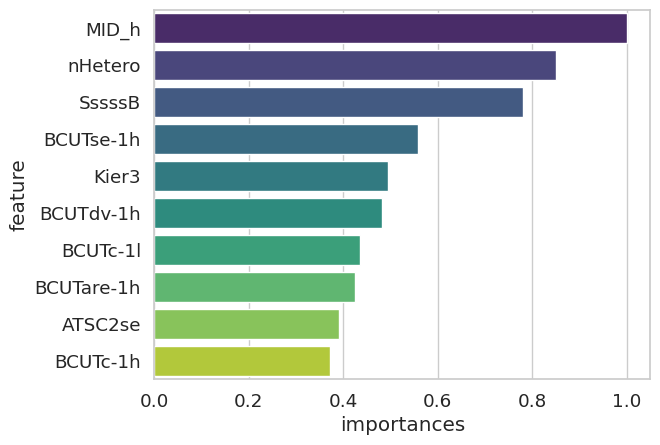

In [15]:
# 特徴量重要度を出す
feature_map_rf = pd.DataFrame([X_train.columns, model_rf_final.feature_importances_]).T
feature_map_rf.columns = ['feature', 'importances']

# 降順に
feature_map_rf = feature_map_rf.sort_values('importances', ascending=False)

# 規格化
feature_map_rf['importances'] = feature_map_rf['importances'] / feature_map_rf['importances'].max()

# 可視化
sns.barplot(y=feature_map_rf['feature'][:10],
            x=feature_map_rf['importances'][:10],
            palette='viridis')
plt.show()

In [ ]:
# ===== 保存したモデルを読み込んで予測する関数 =====
def load_rf_model_and_predict(model_path, scaler_path, X_test_data):
    """
    保存したRandom Forestモデルとスケーラーを読み込んで予測を行う関数
    
    Args:
        model_path: 保存したモデルファイルのパス
        scaler_path: 保存したスケーラーファイルのパス
        X_test_data: 予測したいデータ
    
    Returns:
        予測結果のDataFrame
    """
    # モデルとスケーラーの読み込み
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    
    # データの標準化
    X_test_scaled = scaler.transform(X_test_data)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_data.columns, index=X_test_data.index)
    
    # 予測実行
    predictions = model.predict(X_test_scaled)
    
    # 結果をデータフレームに格納
    results_df = pd.DataFrame({
        'Material': X_test_data.index,
        'Predicted_PL': predictions
    })
    
    return results_df

# 使用例（コメントアウト）
loaded_rf_results = load_rf_model_and_predict('model_rf_final.pkl', 'scaler_rf_final.pkl', X_test)
print("読み込みモデルによる予測結果:")
print(loaded_rf_results)

読み込みモデルによる予測結果:
  Material  Predicted_PL
0    test1    598.541000
1    test2    656.855000
2    test3    622.806000
3    test4    656.362333
4    test5    609.434167


### ADモデル構築

In [17]:
def gamma_optimization_with_variance(x, gammas):
    """
    DataFrame型もしくはarray型のxにおいて、カーネル関数におけるグラム行列の分散を最大化することにより、yを最適化する関数

    Parameters
    -----------------------------------
    x : pandas.DataFrame or numpy.array
    gammas : list

    Returns
    -------
    optimized gamma : scaler

    """

    print('カーネル関数においてグラム行列の分散を最大化することによりγの最適化')

    variance_of_gamma_matrix = []

    for index, ocsvm_gamma in enumerate(gammas):
        print(index + 1, '/', len(gammas))
        gram_matrix = np.exp(-ocsvm_gamma * cdist(x, x, metric='sqeuclidean'))
        variance_of_gamma_matrix.append(gram_matrix.var(ddof=1))

    return gammas[variance_of_gamma_matrix.index(max(variance_of_gamma_matrix))]

In [18]:
# OCSVMによるAD
# OCSVMにおけるnu, nu=0.317(σ), nu=0.045(2σ), nu=0.003(3σ)と選択でき、nuの値が大きくなるとADは狭まるが誤差は小さくなり、
# nuが小さくなるとADは広がるが、誤差は大きくなる
# nu=0.317ならば、約68%のデータが含まれる範囲（±1σ相当）を定義するイメージ
ocsvm_nu = 0.317

# γの候補
ocsvm_gammas = 2 ** np.arange(-20, 11, dtype=float)

# グラム行列の分散を最大化することによるγの候補、最も情報量の多いγを選ぶことができる
optimal_ocsvm_gamma = gamma_optimization_with_variance(autoscaled_X_train, ocsvm_gammas)

print('最適化されたgamma(OCSVM) :', optimal_ocsvm_gamma)

カーネル関数においてグラム行列の分散を最大化することによりγの最適化
1 / 31
2 / 31
3 / 31
4 / 31
5 / 31
6 / 31
7 / 31
8 / 31
9 / 31
10 / 31
11 / 31
12 / 31
13 / 31
14 / 31
15 / 31
16 / 31
17 / 31
18 / 31
19 / 31
20 / 31
21 / 31
22 / 31
23 / 31
24 / 31
25 / 31
26 / 31
27 / 31
28 / 31
29 / 31
30 / 31
31 / 31
最適化されたgamma(OCSVM) : 0.00048828125


In [19]:
# ADモデル構築
ad_model = OneClassSVM(kernel='rbf', gamma=optimal_ocsvm_gamma, nu=ocsvm_nu)

ad_model.fit(autoscaled_X_train)

# 予測データに対してADの内外を判定、学習データの分布（＝高密度領域）を学習する
# データ密度の値
data_density_test = ad_model.decision_function(autoscaled_X_test)
# データ密度が正の値の条件のみ抽出
y_test_pos = y_test_pred.iloc[data_density_test >= 0, :].copy()

y_test_pos

,pred_PL
Material,
test2,656.855000
test3,622.806000
test4,656.362333
test5,609.434167


In [20]:
data_density_test

array([-18.08341558,   3.23502568,   3.48758194,   2.04535175,
         1.75133854])

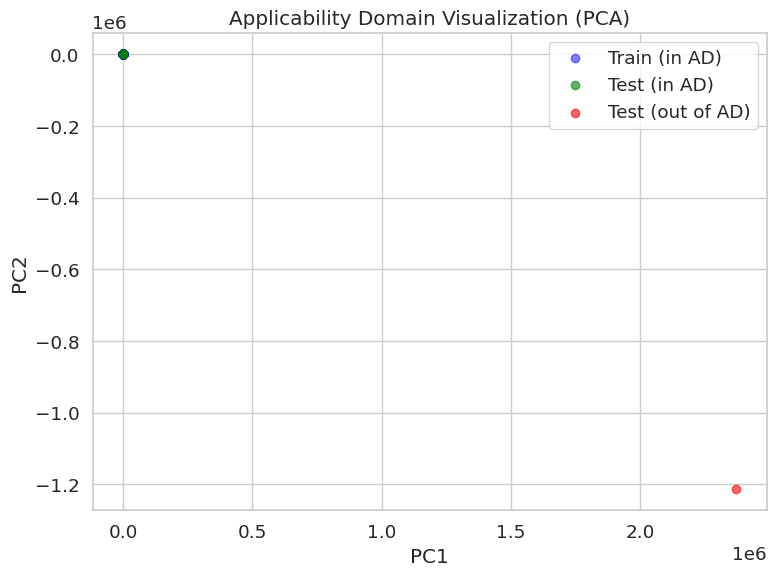

In [21]:
# 可視化、高次元の特徴空間は可視化できないので、PCAなどで2次元に圧縮してプロット

# PCAで2次元に圧縮（学習データでfit）
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(autoscaled_X_train)
X_test_pca = pca.transform(autoscaled_X_test)

# ADの内外を判定
ad_pred_train = ad_model.predict(autoscaled_X_train)  # +1=AD内, -1=AD外
ad_pred_test = ad_model.predict(autoscaled_X_test)

# プロット
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[ad_pred_train==1, 0], X_train_pca[ad_pred_train==1, 1], 
            label='Train (in AD)', color='blue', alpha=0.5)
plt.scatter(X_test_pca[ad_pred_test==1, 0], X_test_pca[ad_pred_test==1, 1], 
            label='Test (in AD)', color='green', alpha=0.6)
plt.scatter(X_test_pca[ad_pred_test==-1, 0], X_test_pca[ad_pred_test==-1, 1], 
            label='Test (out of AD)', color='red', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Applicability Domain Visualization (PCA)')
plt.tight_layout()
plt.show()


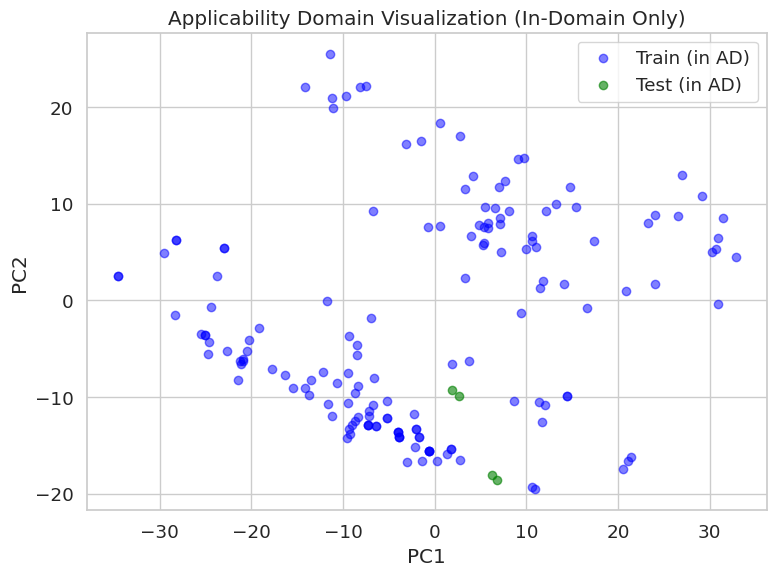

In [23]:
# 可視化の修正案

# AD内のデータのみを抽出
X_train_in_ad_pca = X_train_pca[ad_pred_train==1]
X_test_in_ad_pca = X_test_pca[ad_pred_test==1]

plt.figure(figsize=(8, 6))
plt.scatter(X_train_in_ad_pca[:, 0], X_train_in_ad_pca[:, 1],
            label='Train (in AD)', color='blue', alpha=0.5)
plt.scatter(X_test_in_ad_pca[:, 0], X_test_in_ad_pca[:, 1],
            label='Test (in AD)', color='green', alpha=0.6)

# 必要であれば、AD外のデータもプロットするが、ここではコメントアウト
# plt.scatter(X_test_pca[ad_pred_test==-1, 0], X_test_pca[ad_pred_test==-1, 1],
#             label='Test (out of AD)', color='red', alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Applicability Domain Visualization (In-Domain Only)')
plt.tight_layout()
plt.show()